In [1]:
# Define Parameters
import pandas as pd
import numpy as np
np.random.seed(44)
mock_winnings_data = pd.DataFrame(
    {
        'player_id':np.arange(256),
        'expected_winnings':1 + np.clip(np.random.pareto(2, size=256),0,19),
        'male':[True]*128 + [False]*128,
    }
)

num_competitors = 25


In [3]:
mock_winnings_data.max()

player_id                  255
expected_winnings    10.438596
male                      True
dtype: object

In [173]:
np.random.seed(42)

def create_token_assignments(mock_winnings_data:pd.DataFrame) -> pd.DataFrame:
    """
    Create the token assignments from the random players
    """
    alpha = np.random.random(size=num_competitors)*2 - 1
    alpha[-1] = 10
    expectation = mock_winnings_data['expected_winnings'].to_numpy()
    token_assignment = np.exp(alpha[np.newaxis,:]*expectation[:,np.newaxis])
    token_assignment = 10*token_assignment/(np.sum(token_assignment, axis=0)[np.newaxis,:])

    mock_winnings_data['tokens'] = np.sum(token_assignment, axis=1)
    return mock_winnings_data, token_assignment, alpha

In [174]:
token_df, token_assignment,alphas = create_token_assignments(mock_winnings_data)

In [175]:
def optimise_strategy(tokens:np.ndarray):
    tokens = 10*np.abs(tokens)/np.sum(np.abs(tokens))
    total_tokens = (tokens + token_df['tokens'].to_numpy())
    expected_winnings = np.sum(
        token_df['expected_winnings'].to_numpy()*tokens/total_tokens
    )
    opponent_winnings = token_df['expected_winnings'].to_numpy()[:,np.newaxis]*token_assignment/(total_tokens[:,np.newaxis])
    return -expected_winnings + np.max(np.sum(opponent_winnings,axis=0))

In [176]:
from scipy.optimize import minimize

optimal_solution = minimize(optimise_strategy, 10*np.ones(256)/256)

In [177]:
optimal_solution

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -14.781782861200686
        x: [ 1.645e-01 -6.264e-09 ... -2.653e-10  6.794e-02]
      nit: 480
      jac: [-3.886e-05  2.206e-01 ...  1.309e+00 -2.003e-04]
 hess_inv: [[ 9.837e-01 -2.925e-07 ... -3.431e-06 -1.792e-02]
            [-2.925e-07  1.783e-07 ... -1.858e-08  1.244e-06]
            ...
            [-3.431e-06 -1.858e-08 ...  2.763e-07 -9.488e-07]
            [-1.792e-02  1.244e-06 ... -9.488e-07  9.569e-01]]
     nfev: 144189
     njev: 561

In [178]:
token_df['our_tokens'] = 10*np.abs(optimal_solution.x)/np.sum(np.abs(optimal_solution.x))

In [ ]:
(1/256)*0.1

0.000390625

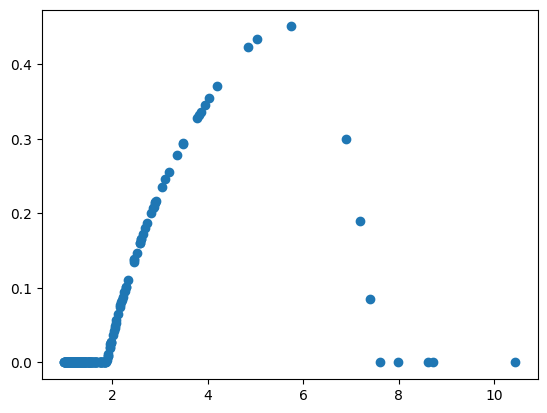

In [180]:
plt.scatter(token_df['expected_winnings'],token_df['our_tokens'])

In [181]:
tokens = 10*np.abs(optimal_solution.x)/np.sum(np.abs(optimal_solution.x))
total_tokens = (tokens + token_df['tokens'].to_numpy())

opponent_winnings = token_df['expected_winnings'].to_numpy()[:,np.newaxis]*token_assignment/(total_tokens[:,np.newaxis])
overall_opp_winings = np.sum(opponent_winnings,axis=0)

Text(0.5, 0, 'alpha')

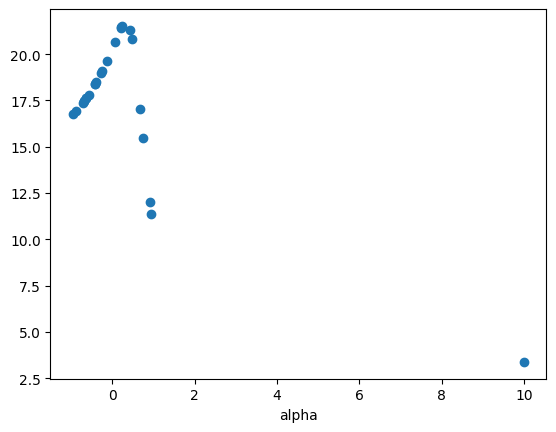

In [182]:
plt.scatter(alphas,overall_opp_winings)
plt.xlabel('alpha')